In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time
from scipy.stats import rankdata

In [2]:
def lap_noise(data, epsilon, K, N, M):
    pri_data = data + np.random.laplace(loc = 0.0, scale = (2*K*8*(N-1)/N)/epsilon, size=data.shape)
    
    min = 10000
    
    for i in range(M):
        if pri_data[i] > 0 and pri_data[i] < min:
            min = pri_data[i]
    
    for i in range(M):
        if pri_data[i] < 0:
            pri_data[i] = min
    
    return pri_data

In [3]:
def hs(n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    
    if h == 0:
        return 0
    else:
        return ((2*i+2*j-h)**2)/h

def SHD_hs(cc,n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    T = hs(n)
    
    d = np.zeros(2)
    N = np.zeros(10)
    
    for k in range(10):
        N[k] = n[k]
    
    if T < cc:
        while T < cc:
            if N[4] > 0: N[4] -= 1
            elif N[1] > 0: N[1] -= 1
            elif N[5] > 0: N[5] -= 1
            elif N[7] > 0: N[7] -= 1
            elif N[0] > 0: N[0] -= 1
            elif N[2] > 0: N[2] -= 1
            else: N[3] -= 1
            N[9] += 1
            
            T = hs(N)
            d[0] -= 1
        
        T = hs(n)
        for k in range(10):
            N[k] = n[k]
        
        while T < cc:
            if N[6] > 0: N[6] -= 1
            elif N[8] > 0: N[8] -= 1
            elif N[9] > 0: N[9] -= 1
            elif N[2] > 0: N[2] -= 1
            elif N[3] > 0: N[3] -= 1
            elif N[5] > 0: N[5] -= 1
            elif N[7] > 0: N[7] -= 1
            elif N[0] > 0: N[0] -= 1
            else: N[1] -= 1
            N[4] += 1
            
            T = hs(N)
            d[1] -= 1
        
        if d[0] > d[1]:
            return d[0]
        else:
            return d[1]
        
    else:
        step = 0
        
        for k in range(10):
            N[k] = n[k]
            
        if i+j > h/2:
            while T >= cc:
                if N[6] > 0: N[6] -= 1
                elif N[8] > 0: N[8] -= 1
                elif N[9] > 0: N[9] -= 1
                elif N[2] > 0: N[2] -= 1
                elif N[3] > 0: N[3] -= 1
                elif N[0] > 0: N[0] -= 1
                elif N[5] > 0: N[5] -= 1
                elif N[7] > 0: N[7] -= 1
                else: N[1] -= 1
                N[4] += 1
                
                T = hs(N)
                step += 1
        else:
            while T >= cc:
                if N[4] > 0: N[4] -= 1
                elif N[1] > 0: N[1] -= 1
                elif N[0] > 0: N[0] -= 1
                elif N[5] > 0: N[5] -= 1
                elif N[7] > 0: N[7] -= 1
                elif N[2] > 0: N[2] -= 1
                else: N[3] -= 1
                N[9] += 1
                
                T = hs(N)
                step += 1
                
        return step-1

In [4]:
def appx_SHD_hs(cc,n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    T = hs(n)
    
    if T < cc:
        if i+j >= h/2:
            if h <= cc:
                return -math.ceil((cc-(i+j))/2)
            else:
                return -math.ceil(((h+math.sqrt(h*cc))/2 - (i+j))/2)
        else:
            if h <= cc:
                return -math.ceil((cc-h+i+j)/2)
            else:
                return -math.ceil((i+j - (h-math.sqrt(h*cc))/2)/2)
    else:
        if i+j >= h/2:
            return math.ceil((i+j - (h+math.sqrt(h*cc))/2)/2) - 1
        else:
            return math.ceil(((h-math.sqrt(h*cc))/2 - (i+j))/2)-1

In [5]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(shd, m, K, epsilon):
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * shd[i] / (2*K))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
        
        x = random_num(p)
        shd[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

Text(0, 0.5, 'chi^2-hs')

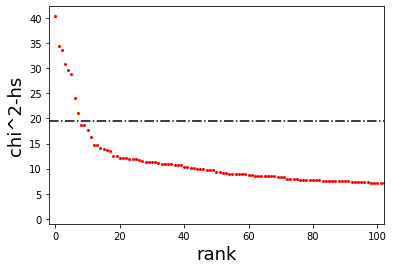

In [6]:
N = 150
M = 5000
H = np.zeros(M)
I = np.zeros(M)
J = np.zeros(M)

n = np.zeros((M,10))

for i in range(M-10):
    n[i][4] = np.random.binomial(2*N, 1/5)
    S = np.random.binomial(2*N-n[i][4], 1/4) #n7+n9+n10
    n[i][6] = np.random.binomial(S, 1/3)
    n[i][8] = np.random.binomial(S-n[i][6], 1/3)
    n[i][9] = S-n[i][6]-n[i][8]
    n[i][1] = np.random.binomial(2*N-n[i][4]-S, 1/3)
    T = np.random.binomial(2*N-n[i][4]-n[i][1]-S, 1/2) #n3+n4
    n[i][2] = np.random.binomial(T, 1/2)
    n[i][3] = T - n[i][2]
    R = 2*N-n[i][4]-n[i][1]-S-T
    n[i][0] = np.random.binomial(R, 1/3)
    n[i][5] = np.random.binomial(R-n[i][0], 1/2)
    n[i][7] = R - n[i][0] - n[i][5]
    
    H[i] = n[i][1]+n[i][2]+n[i][3] + 2*(n[i][4]+n[i][5]+n[i][6]+n[i][7]+n[i][8]+n[i][9])
    I[i] = n[i][3]+n[i][7]+n[i][8] + 2*n[i][9]
    J[i] = n[i][2]+n[i][5] + 2*n[i][6] + n[i][8]
    
for i in range(M-10,M):
    n[i][4] = np.random.binomial(2*N, 1.5/5)
    S = np.random.binomial(2*N-n[i][4], 1/4) #n7+n9+n10
    n[i][6] = np.random.binomial(S, 1/3)
    n[i][8] = np.random.binomial(S-n[i][6], 1/3)
    n[i][9] = S-n[i][6]-n[i][8]
    n[i][1] = np.random.binomial(2*N-n[i][4]-S, 1.5/3)
    T = np.random.binomial(2*N-n[i][4]-n[i][1]-S, 1/2) #n3+n4
    n[i][2] = np.random.binomial(T, 1/2)
    n[i][3] = T - n[i][2]
    R = 2*N-n[i][4]-n[i][1]-S-T
    n[i][0] = np.random.binomial(R, 1/3)
    n[i][5] = np.random.binomial(R-n[i][0], 1/2)
    n[i][7] = R - n[i][0] - n[i][5]
    
    H[i] = n[i][1]+n[i][2]+n[i][3] + 2*(n[i][4]+n[i][5]+n[i][6]+n[i][7]+n[i][8]+n[i][9])
    I[i] = n[i][3]+n[i][7]+n[i][8] + 2*n[i][9]
    J[i] = n[i][2]+n[i][5] + 2*n[i][6] + n[i][8]

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if H[i] == 0:
        stats[i] = 0
    else:
        stats[i] = ((2*I[i] + 2*J[i] - H[i])**2)/H[i]

x = np.argsort(stats)
sorted_stats = sorted(stats, reverse=True)

fig = plt.figure()
plt.ylim(-1, max(stats)+2)
plt.xlim(-2, 102)
plt.plot(order, sorted_stats, marker="o", markersize=2, color = "red", linestyle = "None")
plt.axhline(19.5, color = "black", linestyle = "-.")
plt.xlabel("rank", fontsize = 18)
plt.ylabel("chi^2-hs", fontsize = 18)
#fig.savefig("stats-hs-small.png")
#fig.savefig("fig/stats-hs-small.eps")

In [7]:
cc = 19.5
appx_shd = np.zeros(M)
shd = np.zeros(M)

for i in range(M):
    k = [int(n[i][0]), int(n[i][1]), int(n[i][2]), int(n[i][3]), int(n[i][4]), int(n[i][5]), int(n[i][6]), int(n[i][7]), int(n[i][8]), int(n[i][9])]
    appx_shd[i] = appx_SHD_hs(cc,k)
    shd[i] = SHD_hs(cc,k)

print(appx_shd)
print(shd)

[-14. -20. -16. ...   2.   5.   5.]
[-14. -20. -16. ...   2.   5.   5.]


In [8]:
def rankError_Lap(data,epsilon, K, N, M):
    RE = 0
    for j in range(50):
        noisy_stats = lap_noise(np.array(data), epsilon, K, N, M)
        noisy_rank = rankdata(-noisy_stats)
        #print(noisy_rank)
        for i in range(K):
            for j in range(M):
                if noisy_rank[j] == i+1:
                    RE += math.fabs(j-i)
    RE /= (K*50)
    return RE

In [9]:
def rankError_Exp(x, appx_shd, shd, epsilon, K, N, M):
    RE = np.zeros(2)
    cc = 19.5
    
    #print(x)
        
    APPX = np.zeros(M)
    SHD = np.zeros(M)
        
    for j in range(50):
            
        for i in range(M):
            APPX[i] = appx_shd[i]
            SHD[i] = shd[i]
        
        #print(APPX)
        #print(SHD)
        
        appx_result = exp_mec(APPX, M, K, epsilon)
        exact_result = exp_mec(SHD, M, K, epsilon)
        #print(appx_result)
        #print(rank[int(appx_result[0])])
        #print(exact_result)
        for k in range(K):
            for l in range(M):
                if(appx_result[k] == x[M-1-l]):
                    RE[0] += math.fabs(k-l)
                    break
            for l in range(M):
                if(exact_result[k] == x[M-1-l]):
                    RE[1] += math.fabs(k-l)
                    break
    RE /= (K*50)
    return RE

In [10]:
K = 1
N = 150
M = 5000

RE = np.zeros((7,3))
sum_re = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[0]
        RE[i][2] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[1]
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[2.614032e+03 2.211640e+03 2.123948e+03]
 [2.383416e+03 8.035320e+02 6.811480e+02]
 [2.317700e+03 1.046800e+01 4.280000e+00]
 [2.129260e+03 2.800000e-01 2.040000e-01]
 [1.140576e+03 4.400000e-02 4.400000e-02]
 [2.913960e+02 1.200000e-02 2.000000e-02]
 [4.651600e+01 0.000000e+00 0.000000e+00]]


In [11]:
K = 2
N = 150
M = 5000

RE = np.zeros((7,3))
sum_re = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[0]
        RE[i][2] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[1]
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[2.433558e+03 2.432188e+03 2.415206e+03]
 [2.392102e+03 1.800238e+03 1.758378e+03]
 [2.346768e+03 7.253300e+02 8.653240e+02]
 [2.276748e+03 3.406000e+00 5.626000e+00]
 [2.162870e+03 9.620000e-01 9.340000e-01]
 [2.052918e+03 6.280000e-01 5.980000e-01]
 [1.650490e+03 4.780000e-01 4.600000e-01]]


In [12]:
K = 3
N = 150
M = 5000

RE = np.zeros((7,3))
sum_re = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[0]
        RE[i][2] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[1]
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[2.52105200e+03 2.40371467e+03 2.25648133e+03]
 [2.44661733e+03 2.08150533e+03 1.95020000e+03]
 [2.46680400e+03 1.52052533e+03 1.58786800e+03]
 [2.49557333e+03 2.27734667e+02 2.61228000e+02]
 [2.26393333e+03 9.81733333e+00 6.86533333e+00]
 [2.38895867e+03 2.89466667e+00 1.74800000e+00]
 [2.11510133e+03 9.74666667e-01 9.16000000e-01]]


In [13]:
K = 5
N = 150
M = 5000

RE = np.zeros((7,3))
sum_re = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[0]
        RE[i][2] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[1]
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[2550.1184 2534.4432 2369.688 ]
 [2507.4312 2219.8712 2232.7832]
 [2480.0768 1968.2552 1840.2776]
 [2430.4464 1168.2912 1156.3424]
 [2439.5504  363.3664  374.6904]
 [2317.78    109.7704   72.8144]
 [2254.6288   19.6008   10.7304]]


In [14]:
K = 10
N = 150
M = 5000

RE = np.zeros((7,3))
sum_re = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[0]
        RE[i][2] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[1]
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[2494.8184 2471.6344 2437.5308]
 [2456.4548 2386.5652 2399.2824]
 [2472.7508 2199.18   2252.6344]
 [2489.928  1966.9516 1906.9384]
 [2452.9076 1571.1492 1536.9432]
 [2369.674  1225.1124 1160.    ]
 [2398.1348  751.2496  820.4036]]
